In [28]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
ds, ds_withinfo = tfds.load('food101',  shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

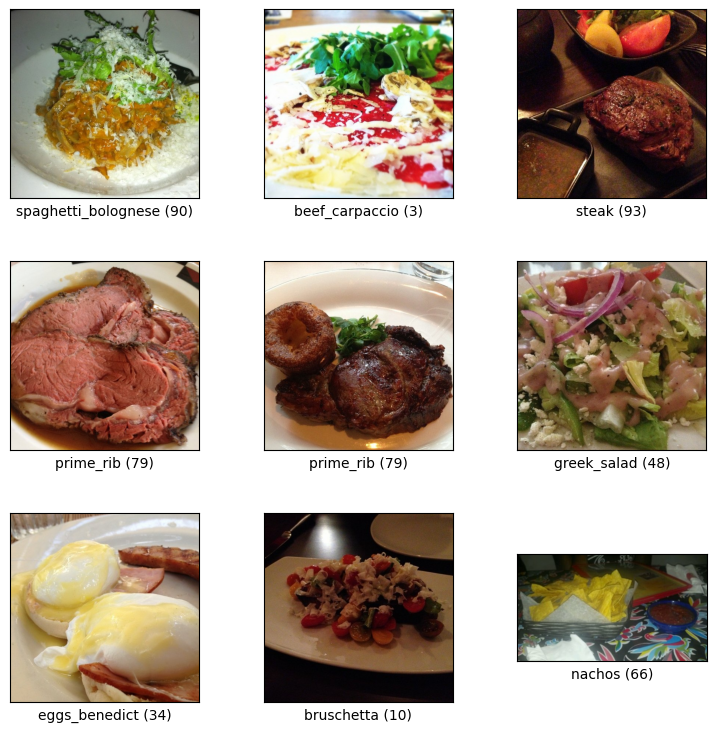

In [6]:
figure = tfds.show_examples(train_ds, ds_withinfo)

In [7]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

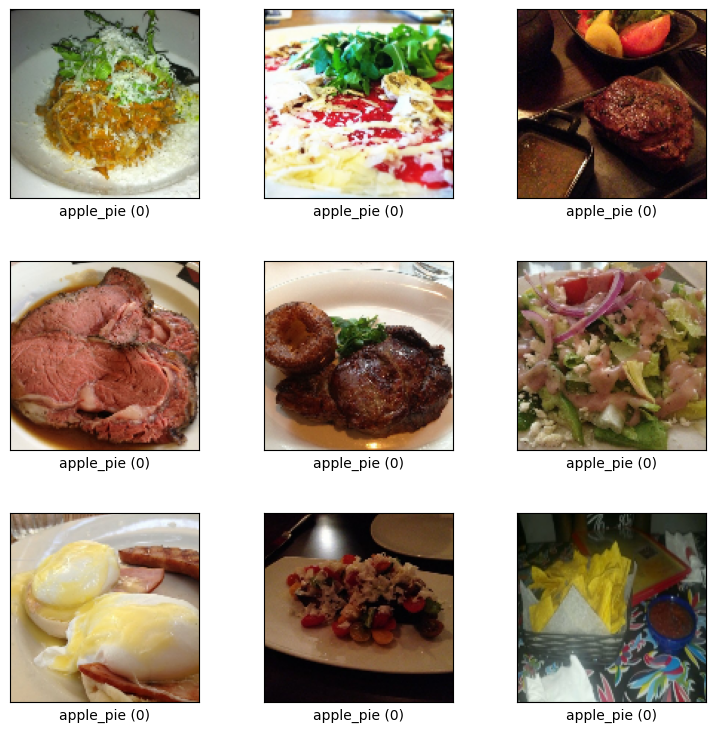

In [8]:
figure = tfds.show_examples(train_ds, ds_withinfo)

In [57]:
train_hd_size, valid_hd_size = 750,250
train_hotdogs = train_ds.filter(lambda image, label: label==1)
train_nothotdogs = train_ds.filter(lambda image, label: label==0)

In [58]:
valid_hotdogs = valid_ds.filter(lambda image, label: label==1)
valid_nothotdogs = valid_ds.filter(lambda image, label: label==0)

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[179 155 111]
   [181 158 116]
   [182 159 120]
   ...
   [171 137  91]
   [159 122  79]
   [122  84  37]]

  [[172 148 104]
   [173 148 107]
   [172 149 109]
   ...
   [150 118  64]
   [150 116  59]
   [146 111  49]]

  [[170 143 100]
   [168 142 101]
   [166 141 102]
   ...
   [155 125  64]
   [189 154 108]
   [151 113  77]]

  ...

  [[199 194 141]
   [198 190 137]
   [204 171 100]
   ...
   [230 225 184]
   [231 226 188]
   [230 225 188]]

  [[202 197 148]
   [200 193 139]
   [205 187 124]
   ...
   [230 224 187]
   [231 225 190]
   [229 224 186]]

  [[204 198 150]
   [201 193 140]
   [195 186 129]
   ...
   [230 223 192]
   [231 224 195]
   [230 224 189]]]


 [[[106 107 101]
   [110 111 103]
   [112 113 105]
   ...
   [119 144 154]
   [115 142 152]
   [113 141 152]]

  [[108 111 102]
   [113 116 108]
   [113 116 108]
   ...
   [123 146 160]
   [120 146 161]
   [117 143 158]]

  [[109 112 103]
   [113 116 108]
   [114 117 110]
   ...
   [122 145 162]
   [125 150 167]


#Neural Net

In [13]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu', input_shape= [MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2 ,2))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2 ,2))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [14]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [15]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
95/95 [==============================] - 172s 2s/step - loss: 0.6895 - accuracy: 0.5056 - val_loss: 0.6784 - val_accuracy: 0.5204
Epoch 2/50
95/95 [==============================] - 2s 25ms/step - loss: 0.6569 - accuracy: 0.5533 - val_loss: 0.6541 - val_accuracy: 0.5903
Epoch 3/50
95/95 [==============================] - 2s 22ms/step - loss: 0.6188 - accuracy: 0.6083 - val_loss: 0.6233 - val_accuracy: 0.6252
Epoch 4/50
95/95 [==============================] - 2s 22ms/step - loss: 0.5744 - accuracy: 0.6521 - val_loss: 0.6064 - val_accuracy: 0.6757
Epoch 5/50
95/95 [==============================] - 2s 22ms/step - loss: 0.5199 - accuracy: 0.7150 - val_loss: 0.5983 - val_accuracy: 0.6699
Epoch 6/50
95/95 [==============================] - 2s 24ms/step - loss: 0.4580 - accuracy: 0.7581 - val_loss: 0.5945 - val_accuracy: 0.6777
Epoch 7/50
95/95 [==============================] - 2s 23ms/step - loss: 0.3984 - accuracy: 0.8065 - val_loss: 0.6089 - val_accuracy: 0.6757
Epoch 8/50
95

In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [27]:
for i,_ in ds["train"].take(1):
  image = i

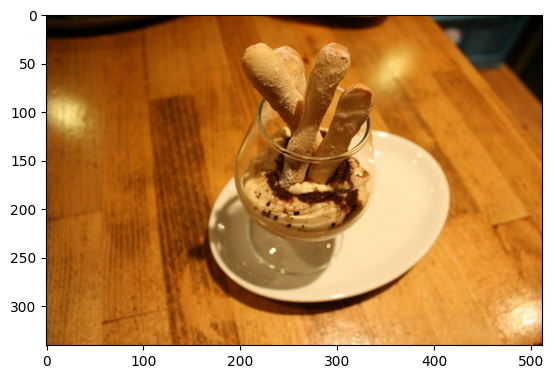

In [28]:
plt.imshow(image)

In [29]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

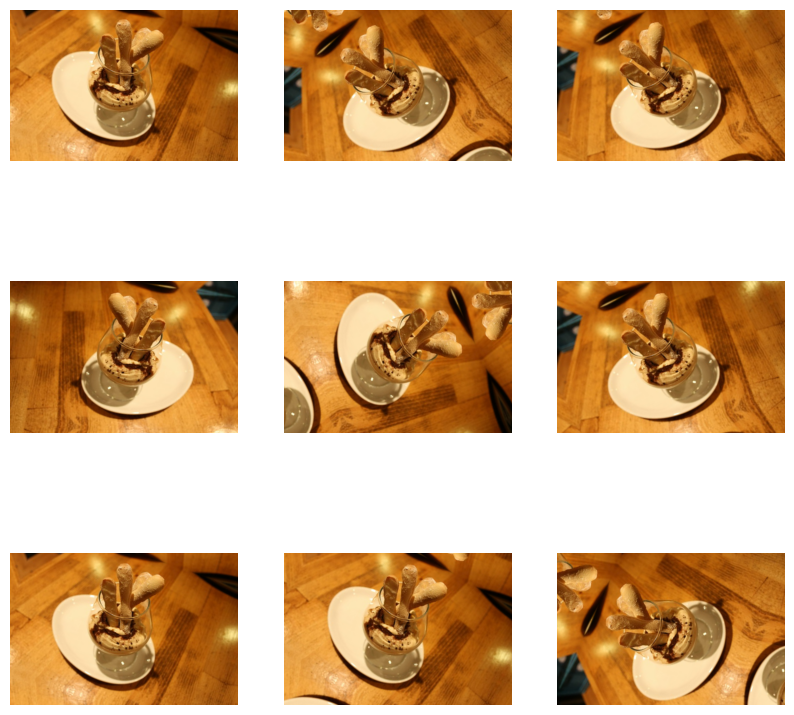

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [31]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [32]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])


In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
100/100 [==============================] - 150s 1s/step - loss: 1.8046 - accuracy: 0.5293 - val_loss: 1.6315 - val_accuracy: 0.5292
Epoch 2/50
100/100 [==============================] - 3s 35ms/step - loss: 1.4979 - accuracy: 0.5274 - val_loss: 1.3742 - val_accuracy: 0.5292
Epoch 3/50
100/100 [==============================] - 4s 35ms/step - loss: 1.2891 - accuracy: 0.5255 - val_loss: 1.1998 - val_accuracy: 0.5348
Epoch 4/50
100/100 [==============================] - 3s 33ms/step - loss: 1.1445 - accuracy: 0.5343 - val_loss: 1.0793 - val_accuracy: 0.5461
Epoch 5/50
100/100 [==============================] - 3s 33ms/step - loss: 1.0350 - accuracy: 0.5413 - val_loss: 0.9880 - val_accuracy: 0.5932
Epoch 6/50
100/100 [==============================] - 4s 41ms/step - loss: 0.9636 - accuracy: 0.5570 - val_loss: 0.9230 - val_accuracy: 0.6121
Epoch 7/50
100/100 [==============================] - 4s 39ms/step - loss: 0.9035 - accuracy: 0.5734 - val_loss: 0.8747 - val_accuracy: 0.6158